# Impute missing values using kNN

In [1]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KNeighborsRegressor as kNN
from tqdm import tqdm
%matplotlib inline

## load the data

In [2]:
#load_data
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections'].tolist()
original_shape = data.shape

### define kNN method to do imputation

In [3]:
#define_model

class kNN_imputation:
    def __init__(self, 
                 n_neighbors = 1,
                 weights = 'uniform',
                 metric = 'euclidean'):
        ''' Init function of kNN_imputation
        
        '''
        self.model = kNN(n_neighbors=n_neighbors, metric=metric, weights = weights, n_jobs=4)
    def fit_transform(self, X, template, inplace = False):
        '''
        Input:
          X : 4d array, missing values are -1.
          template : 0-1 3d array, 1 means the voxel is of interest. 
        '''
        if inplace:
            Y = X
        else:
            Y = np.copy(X)
        for ind in tqdm(range(X.shape[0])):
            self.fit_transform_one_img(Y[ind,:,:,:], template, inplace=True)
        return Y
         
        
    def fit_transform_one_img(self, X, template, inplace = False):
        '''
        Input:
          X : 3d array, missing values are -1.
          template : 0-1 3d array, 1 means the voxel is of interest. 
        '''
        long_form = []
        for x in range(X.shape[0]):
            for y in range(X.shape[1]):
                for z in range(X.shape[2]):
                    if template[x, y, z] > 0:
                        long_form.append([x, y, z, X[x, y, z]])
        long_form = np.array(long_form)
        train_ind = long_form[:,3] >= 0
        test_ind = long_form[:,3] < 0
        X_train = long_form[train_ind,:3].astype(int)
        y_train = long_form[train_ind,3]
        X_test = long_form[test_ind, :3].astype(int)
        self.model.fit(X_train, y_train)
        y_test = self.model.predict(X_test)
        if inplace:
            Y = X
        else:
            Y = np.copy(X)
        for ind, (x, y, z) in enumerate(X_test):
            Y[x, y, z] = y_test[ind]
        return Y
        

In [ ]:
# fit_model
model = kNN_imputation(n_neighbors=6, weights='distance')
imputed = model.fit_transform(data, np.ones_like(data[0,:,:,:]), inplace=True)

 38%|███▊      | 1667/4345 [43:46<1:10:01,  1.57s/it]

In [ ]:
#store_data
np.savez("../data/imputed_data_kNN_neighbor_6_weights_distance.npz",imputed=imputed)

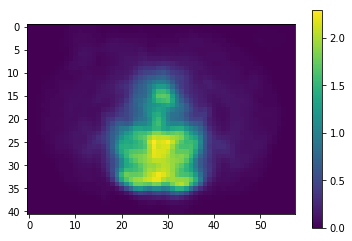

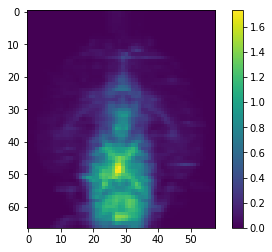

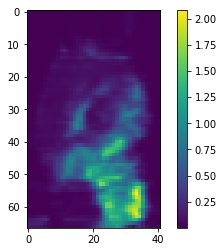

In [47]:
#visualize a specific gene in the gene_index
i = 9
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 0))
plt.colorbar()
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 1))
plt.colorbar()
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 2))
plt.colorbar()
plt.show()